In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

from dms_3d_features.plotting import plot_pop_avg_from_row, publication_style_ax, plot_motif_boxplot_stripplot

In [2]:
DATA_PATH = "../data"

In [3]:
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df["ln_r_data"] = np.log(df["r_data"])

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
df_non_wc = df.query("r_type == 'NON-WC'")
df_wc = df.query("r_type == 'WC'")

In [5]:
df.columns

Index(['both_purine', 'both_pyrimidine', 'constructs', 'has_pdbs',
       'likely_pair', 'm_flank_bp_5p', 'm_flank_bp_3p', 'm_orientation',
       'm_pos', 'm_second_flank_bp_5p', 'm_second_flank_bp_3p', 'm_sequence',
       'm_structure', 'm_token', 'n_pdbs', 'pair_type', 'p5_res', 'p5_type',
       'p3_res', 'p3_type', 'r_data', 'r_nuc', 'r_loc_pos', 'r_pos', 'r_type',
       'r_basepair_type', 'r_pdb_nuc_pair', 'pdb_path', 'ln_r_data'],
      dtype='object')

## probablity of being WC

In [6]:
filtered_column = df['r_data'][df['r_data'] != 0]
min_value = filtered_column.min()
print(min_value) # approximately ln(min_value) = -9.8


6.000000000000001e-05


In [7]:
# set -inf values to -9.8 the lowest value found
df['ln_r_data'].replace(-np.inf, -9.8, inplace=True)
df["ln_r_data"].describe()

count    237528.000000
mean         -5.090383
std           1.367047
min          -9.800000
25%          -6.319969
50%          -5.057727
75%          -3.966479
max          -0.691768
Name: ln_r_data, dtype: float64

In [8]:
# Convert 'r_type' to binary (1 for 'WC', 0 for 'NON-WC')
df['r_type_binary'] = df['r_type'].apply(lambda x: 1 if x == 'WC' else 0)
# Fit the logistic regression model
model = LogisticRegression()
model.fit(df[['ln_r_data']], df['r_type_binary'])
# Compute probabilities for the original data
df['prob_WC'] = model.predict_proba(df[['ln_r_data']])[:, 1]
# Display the probabilities
df.sort_values('prob_WC', ascending=False)[['ln_r_data', 'r_type', 'prob_WC']]

ln_r_data  r_type   prob_WC
136078  -9.800000      WC  0.999996
28731   -9.800000      WC  0.999996
66506   -9.800000      WC  0.999996
58333   -9.800000      WC  0.999996
8841    -9.800000      WC  0.999996
...           ...     ...       ...
234212  -1.013022  NON-WC  0.000003
234179  -0.994414  NON-WC  0.000003
55879   -0.972755  NON-WC  0.000003
55890   -0.853363  NON-WC  0.000002
234188  -0.691768  NON-WC  0.000001

[237528 rows x 3 columns]

In [9]:

# Calculate the absolute difference between each value in the column 'prob_WC' and 0.5
df['abs_diff'] = (df['prob_WC'] - 0.10).abs()

# Find the index of the minimum difference
min_index = df['abs_diff'].idxmin()

# Retrieve the entire row that is closest to 0.5 in the 'prob_WC' column
closest_row = df.loc[min_index]

print("The row with the value in 'prob_WC' closest to 0.5 is:")
print(closest_row["ln_r_data"])

The row with the value in 'prob_WC' closest to 0.5 is:
-4.684213393328545


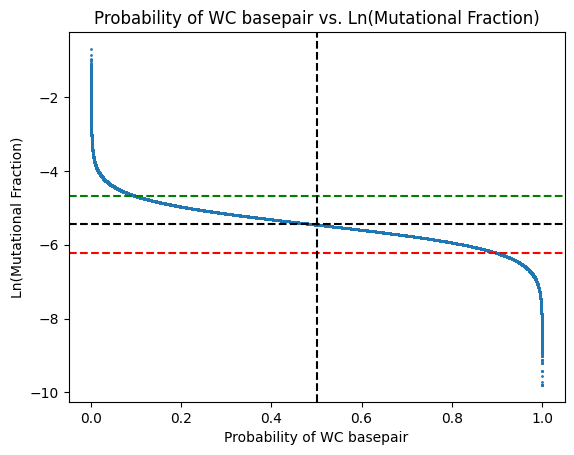

In [10]:
plt.scatter(df['prob_WC'], df['ln_r_data'], s=1)
plt.title('Probability of WC basepair vs. Ln(Mutational Fraction)')
plt.xlabel('Probability of WC basepair')
plt.ylabel('Ln(Mutational Fraction)')
plt.axhline(y=-4.68, color='green', linestyle='--') # 10% probability threshold (0.00927901)
plt.axhline(y=-5.45, color='black', linestyle='--') # 50% probability threshold (0.0042963)
plt.axhline(y=-6.22, color='red', linestyle='--') # 90% probability threshold (0.00198925)
plt.axvline(x=0.5, color='black', linestyle='--')

In [11]:
df["ln_r_data"].describe()

count    237528.000000
mean         -5.090383
std           1.367047
min          -9.800000
25%          -6.319969
50%          -5.057727
75%          -3.966479
max          -0.691768
Name: ln_r_data, dtype: float64

In [12]:
df_below_50 = df.query("ln_r_data < -5.45 and r_type == 'NON-WC'")
print(len(df_below_50))
df_below_90 = df.query("ln_r_data < -6.22 and r_type == 'NON-WC'")
print(len(df_below_90))


12093
2141


In [13]:
for (nuc, m_token), full_g in df_non_wc.groupby(["r_nuc", "m_token"]):
    full_g = full_g.query(f"has_pdbs == True")
    if len(full_g) == 0:
        continue
    g = df_below_50.query(f"r_nuc == '{nuc}' and m_token == '{m_token}' and has_pdbs == True")
    print(f"{nuc} {m_token} {g.shape[0]}/{full_g.shape[0]}, percentage: {g.shape[0]/full_g.shape[0]*100}")

A 1x0 18/335, percentage: 5.3731343283582085
A 1x1 198/1378, percentage: 14.368650217706822
A 2x0 13/508, percentage: 2.559055118110236
A 2x1 36/2569, percentage: 1.401323472168159
A 2x2 238/1557, percentage: 15.285806037251124
A 3x0 0/245, percentage: 0.0
A 3x1 113/1080, percentage: 10.462962962962962
A 3x2 250/3319, percentage: 7.532389273877674
A 3x3 2/2177, percentage: 0.09186954524575103
A 4x1 1/728, percentage: 0.13736263736263737
A 4x2 36/364, percentage: 9.89010989010989
A 4x3 102/832, percentage: 12.259615384615383
A 4x4 187/1970, percentage: 9.49238578680203
A 5x0 15/312, percentage: 4.807692307692308
A 5x1 8/416, percentage: 1.9230769230769231
A 5x3 80/936, percentage: 8.547008547008547
A 5x4 84/2488, percentage: 3.376205787781351
A 6x3 148/1092, percentage: 13.553113553113553
C 1x0 0/186, percentage: 0.0
C 1x1 202/932, percentage: 21.67381974248927
C 2x0 0/175, percentage: 0.0
C 2x1 1/590, percentage: 0.1694915254237288
C 2x2 282/1171, percentage: 24.08198121263877
C 3x0 0/

In [14]:
df_non_wc.query("m_token == '5x4' and r_nuc == 'C'")["m_sequence"]

208621    GGGAAAG&UAACAC
208622    GGGAAAG&UAACAC
208623    GGGAAAG&UAACAC
208624    GGGAAAG&UAACAC
208625    GGGAAAG&UAACAC
               ...      
234848    UGGGAUU&ACGAAG
234849    UGGGAUU&ACGAAG
234850    UGGGAUU&ACGAAG
234851    UGGGAUU&ACGAAG
234852    UGGGAUU&ACGAAG
Name: m_sequence, Length: 207, dtype: object

## general

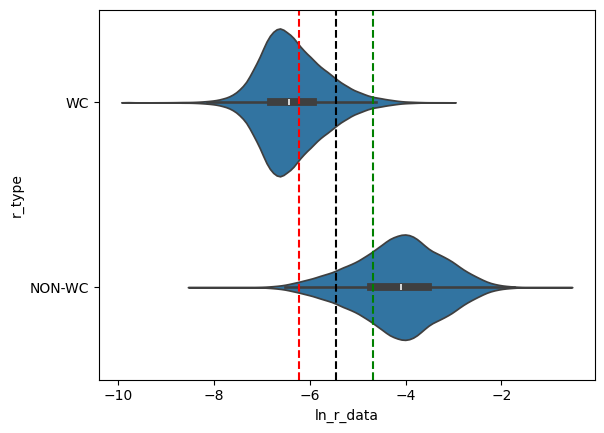

In [15]:
ax = sns.violinplot(x="ln_r_data", y="r_type", data=df)
plt.axvline(x=-4.68, color='green', linestyle='--') # 10% probability threshold (0.00927901)
plt.axvline(x=-5.45, color='black', linestyle='--') # 50% probability threshold (0.0042963)
plt.axvline(x=-6.22, color='red', linestyle='--') # 90% probability threshold (0.00198925)

## everything

## bulges

### 1-0

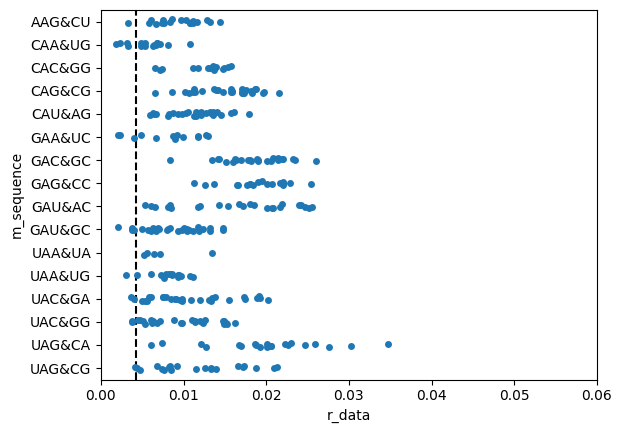

In [16]:
df_sub = df.query("m_token == '1x0' and r_nuc == 'A' and r_type == 'NON-WC'").copy()
df_sub.sort_values("m_sequence", inplace=True)  
ax = sns.stripplot(x="r_data", y="m_sequence", data=df_sub)
ax.set_xlim([0,  0.06])
plt.axvline(x=0.0042963, color='black', linestyle='--')



In [17]:
df.query("m_token == '1x0' and r_nuc == 'A' and r_type == 'NON-WC'")["r_data"].mean()

0.012484059701492538

(0.0, 0.06)

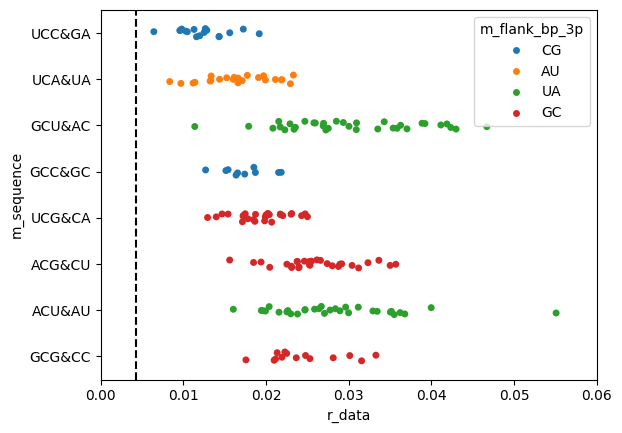

In [18]:
df_sub = df.query("m_token == '1x0' and r_nuc == 'C' and r_type == 'NON-WC'").copy()
df_sub.sort_values("r_data", inplace=True)  
ax = sns.stripplot(x="r_data", y="m_sequence", data=df_sub, hue="m_flank_bp_3p")
plt.axvline(x=0.0042963, color='black', linestyle='--')
ax.set_xlim([0,  0.06])

In [19]:
df.query("m_token == '1x0' and r_nuc == 'C' and r_type == 'NON-WC'")["r_data"].mean()

0.023439946236559143

<Axes: xlabel='r_nuc', ylabel='r_data'>

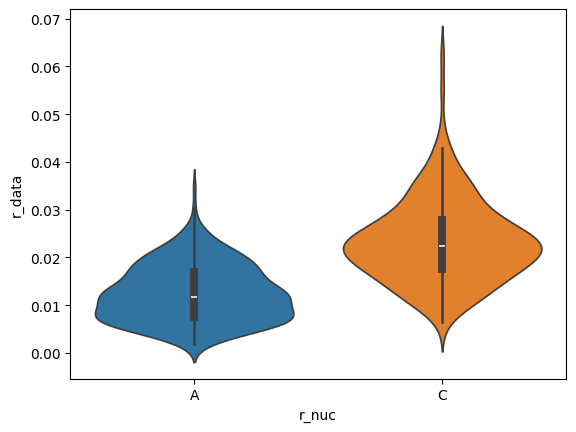

In [20]:
df_sub = df.query("m_token == '1x0' and r_type == 'NON-WC'").copy()
sns.violinplot(x="r_nuc", y="r_data", data=df_sub, hue="r_nuc")


In [21]:
df_sub_1 = df.query("m_token == '1x0' and r_nuc == 'A' and r_type == 'NON-WC'").copy()
df_sub_2 = df.query("m_token == '1x0' and r_nuc == 'C' and r_type == 'NON-WC'").copy()
ks_2samp(df_sub_1["r_data"], df_sub_2["r_data"])

KstestResult(statistic=0.546140266409886, pvalue=2.3831508825696994e-33, statistic_location=0.017050000000000003, statistic_sign=1)

### 2-0

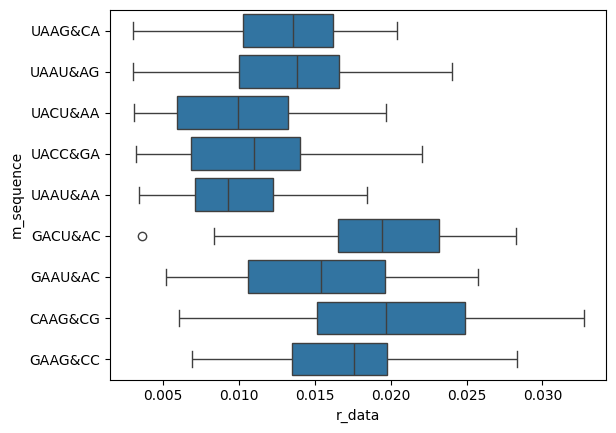

In [22]:
df_sub = df.query("m_token == '2x0' and r_nuc == 'A' and r_type == 'NON-WC'").copy()
df_sub.sort_values("r_data", inplace=True)  
ax = sns.boxplot(x="r_data", y="m_sequence", data=df_sub)

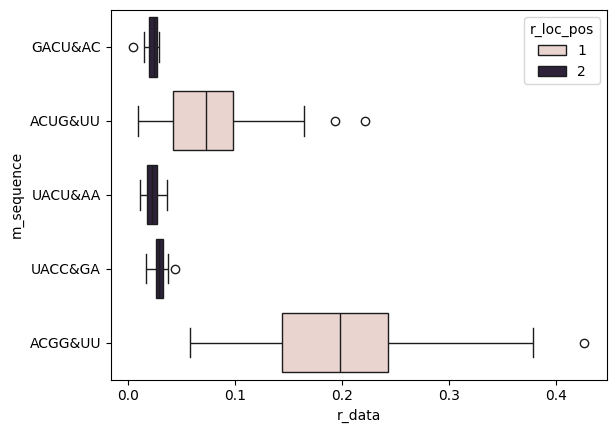

In [23]:
df_sub = df.query("m_token == '2x0' and r_nuc == 'C' and r_type == 'NON-WC'").copy()
df_sub.sort_values("r_data", inplace=True)  
ax = sns.boxplot(x="r_data", y="m_sequence", data=df_sub, hue="r_loc_pos")

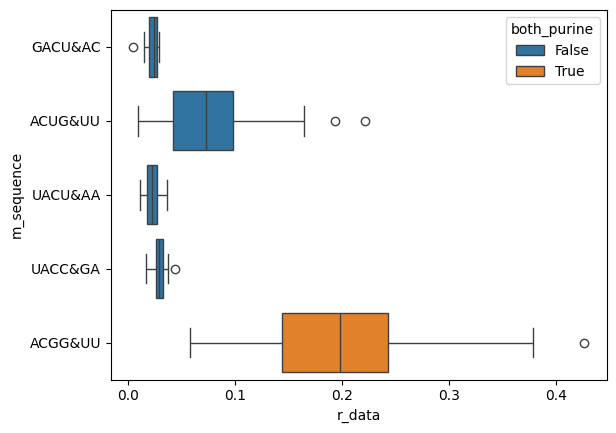

In [24]:
ax = sns.boxplot(x="r_data", y="m_sequence", data=df_sub, hue="both_purine")

<Axes: xlabel='m_token', ylabel='r_data'>

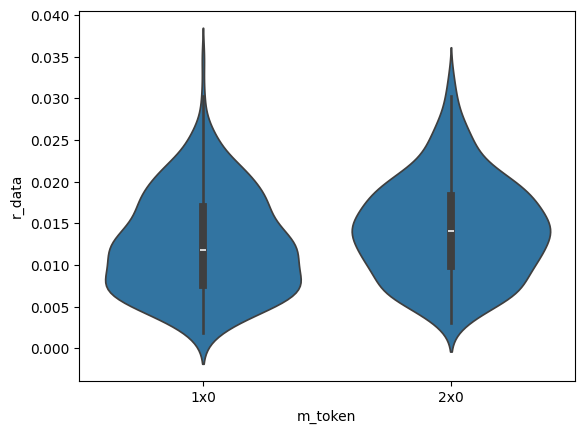

In [25]:
df_sub = df.query("(m_token == '1x0' or m_token == '2x0') and r_nuc == 'A' and r_type == 'NON-WC'").copy()
sns.violinplot(x="m_token", y="r_data", data=df_sub)


### 3-0

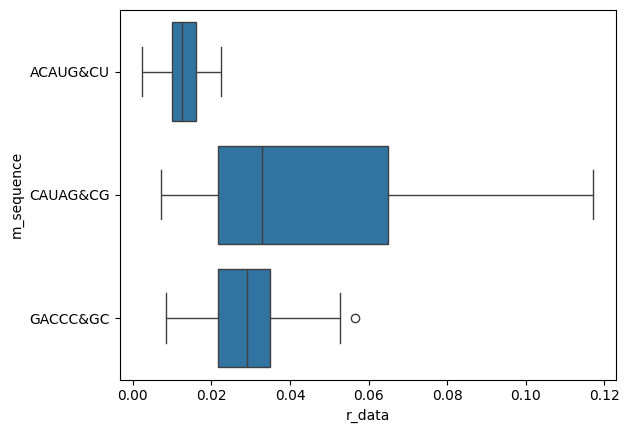

In [26]:
df_sub = df.query("m_token == '3x0' and r_nuc == 'A' and r_type == 'NON-WC'").copy()
df_sub.sort_values("r_data", inplace=True)  
ax = sns.boxplot(x="r_data", y="m_sequence", data=df_sub)

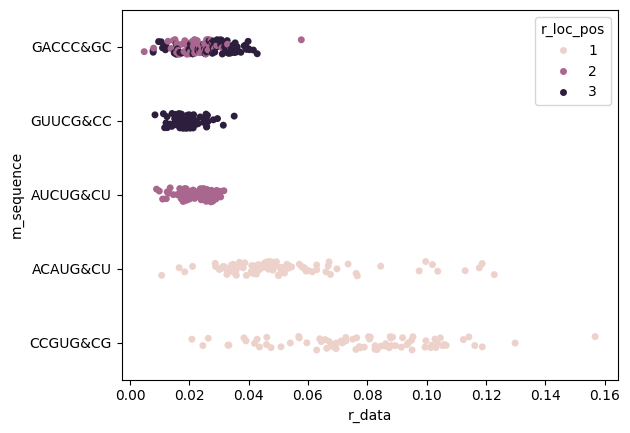

In [27]:
df_sub = df.query("m_token == '3x0' and r_nuc == 'C' and r_type == 'NON-WC'").copy()
df_sub.sort_values("r_data", inplace=True)  
ax = sns.stripplot(x="r_data", y="m_sequence", data=df_sub, hue="r_loc_pos")

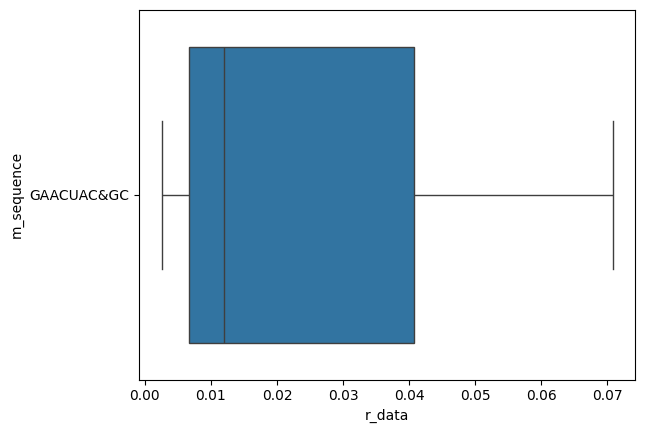

In [28]:
df_sub = df.query("m_token == '5x0' and r_nuc == 'A' and r_type == 'NON-WC'").copy()
df_sub.sort_values("r_data", inplace=True)  
ax = sns.boxplot(x="r_data", y="m_sequence", data=df_sub)

## mismatches

### 1x1

### C mismatches

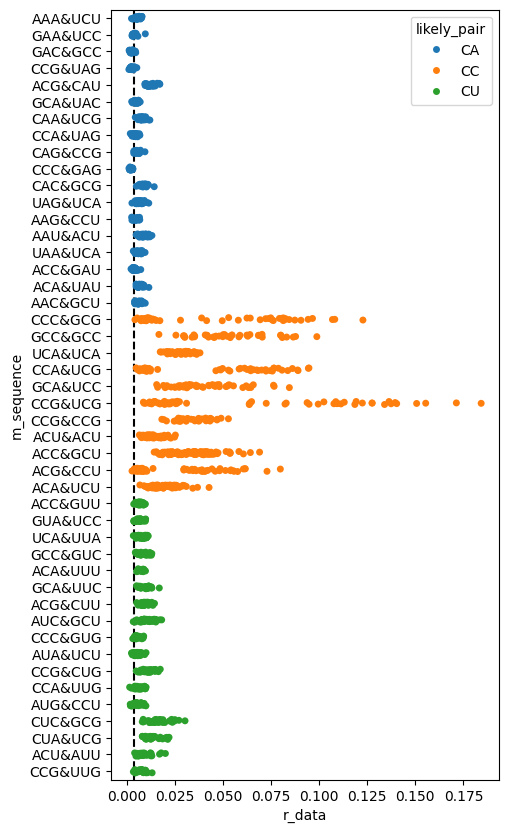

In [29]:
fig, ax = plt.subplots(figsize=(5, 10))
df_sub = df.query("m_token == '1x1' and r_nuc == 'C' and r_type == 'NON-WC'").copy()
df_sub["stack"] = df_sub["p5_res"] + df_sub["p3_res"]
df_sub.sort_values("likely_pair", inplace=True)  
ax = sns.stripplot(x="r_data", y="m_sequence", data=df_sub, hue='likely_pair', ax=ax)
plt.axvline(x=0.00351752, color='black', linestyle='--')

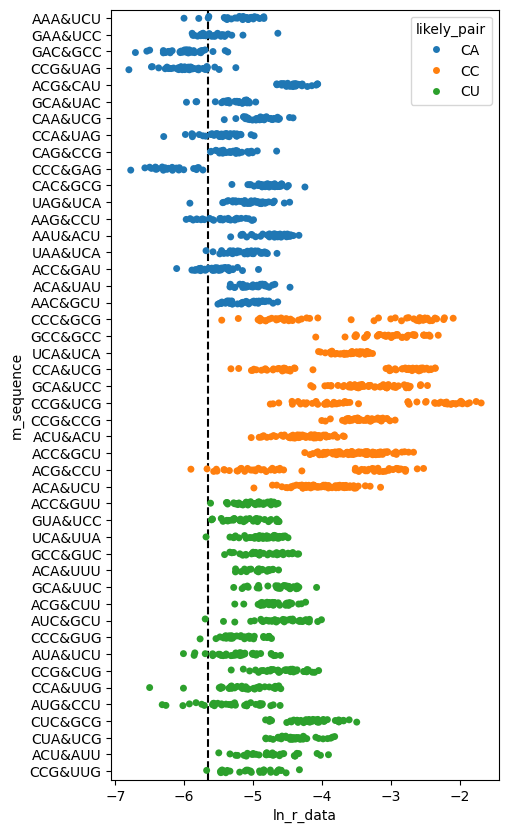

In [30]:
fig, ax = plt.subplots(figsize=(5, 10))
df_sub = df.query("m_token == '1x1' and r_nuc == 'C' and r_type == 'NON-WC'").copy()
df_sub["stack"] = df_sub["p5_res"] + df_sub["p3_res"]
df_sub.sort_values("likely_pair", inplace=True)  
ax = sns.stripplot(x="ln_r_data", y="m_sequence", data=df_sub, hue='likely_pair', ax=ax)
plt.axvline(x=-5.65, color='black', linestyle='--')

<Axes: xlabel='r_data', ylabel='stack'>

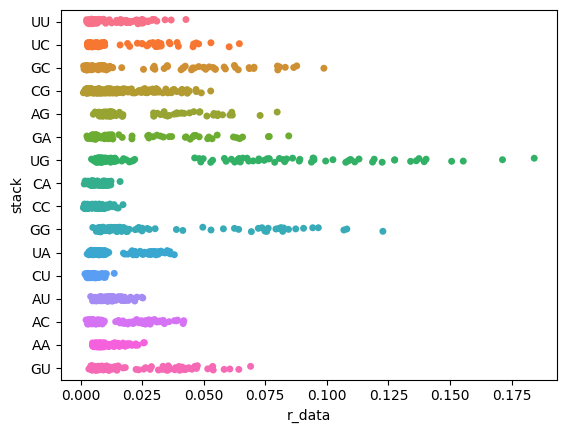

In [31]:
sns.stripplot(x="r_data", y="stack", data=df_sub, hue="stack")

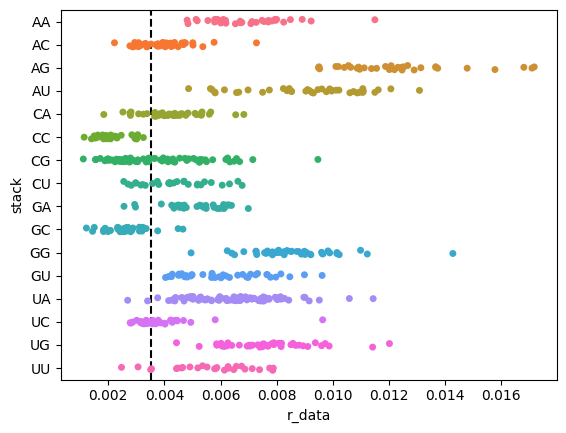

In [32]:
df_sub_2 = df_sub.query('likely_pair == "CA"').copy()
df_sub_2.sort_values("stack", inplace=True)  
sns.stripplot(x="r_data", y="stack", data=df_sub_2, hue="stack")
plt.axvline(x=0.00351752, color='black', linestyle='--')

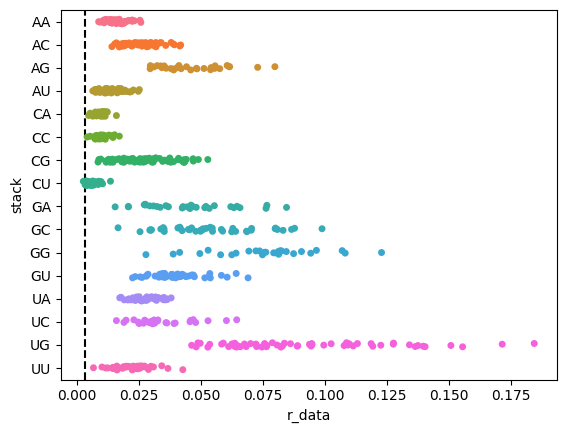

In [33]:
df_sub_2 = df_sub.query('likely_pair == "CC"').copy()
df_sub_2.sort_values("stack", inplace=True)  
sns.stripplot(x="r_data", y="stack", data=df_sub_2, hue="stack")
plt.axvline(x=0.00351752, color='black', linestyle='--')

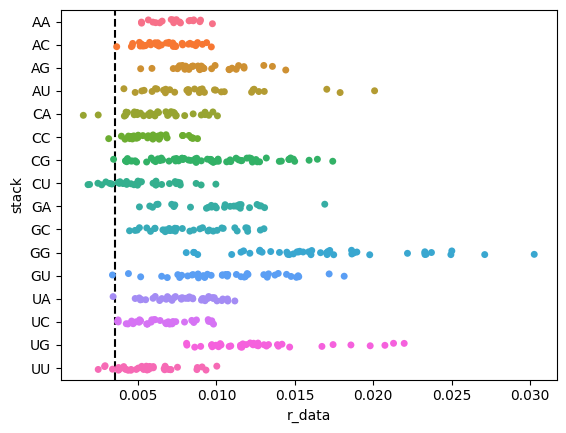

In [34]:
df_sub_2 = df_sub.query('likely_pair == "CU"').copy()
df_sub_2.sort_values("stack", inplace=True)  
sns.stripplot(x="r_data", y="stack", data=df_sub_2, hue="stack")
plt.axvline(x=0.00351752, color='black', linestyle='--')

In [35]:
count_wc = 0
count_non_wc = 0
for m_sequence, g in df_sub.query('likely_pair == "CA"').groupby("m_sequence"):
    ks1, p_val = ks_2samp(g["ln_r_data"], df_wc["ln_r_data"])
    ks2, p_val = ks_2samp(g["ln_r_data"], df_non_wc["ln_r_data"])
    if ks1 < ks2:
        print(m_sequence, ks1, ks2, p_val)
        count_wc += 1
    else:
        count_non_wc += 1
count_wc, count_non_wc

AAA&UCU 0.7686975626983318 0.7845498291885538 3.7428432345674485e-18
AAG&CCU 0.7362468322601639 0.8236564669580869 2.0602265446675215e-21
ACC&GAU 0.7437449317336511 0.8345014632234997 4.30907917390388e-33
CCA&UAG 0.7175544555431749 0.8214818352128714 3.690833695053983e-30
CCC&GAG 0.3844273014892166 0.9459207287955038 1.2384041879205078e-34
CCG&UAG 0.5068430897505207 0.8953971146520925 1.602507404975958e-45
GAA&UCC 0.7688067604744954 0.8290727347766054 2.2130227942741866e-26
GAC&GCC 0.5016418013469675 0.8980053631120744 4.345333311123975e-39
GCA&UAC 0.7791075736210975 0.8159938287477501 1.6568385813232065e-24


(9, 9)

In [36]:
df_sub = df.query("m_token == '1x1' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
for m_token, g in df_sub.groupby(["m_sequence"]):
    side_groups = list(g.groupby("r_loc_pos"))
    left = side_groups[0][1]
    right = side_groups[1][1]
    print(m_token, left["r_data"].mean() / right["r_data"].mean(), right["r_data"].mean() / left["r_data"].mean())
    

ACA&UCU 0.7367199672902875 1.3573678526429473
ACC&GCU 0.6648296643341239 1.5041446759172126
ACG&CCU 6.787847579814623 0.14732210590198758
ACU&ACU 1.1976267363780821 0.8349846990091805
CCA&UCG 0.13740637377602594 7.277682777874716
CCC&GCG 0.1322706300582407 7.5602573266619
CCG&CCG 1.0876968491467232 0.9193738133786822
CCG&UCG 0.16599640309299804 6.024226919180644
GCA&UCC 1.3115513521842974 0.7624558492006963
GCC&GCC 0.8380726827276441 1.1932139307360992
UCA&UCA 1.2756224667052687 0.7839310031774855


/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_52637/2252144119.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for m_token, g in df_sub.groupby(["m_sequence"]):


<Axes: xlabel='r_data', ylabel='m_sequence'>

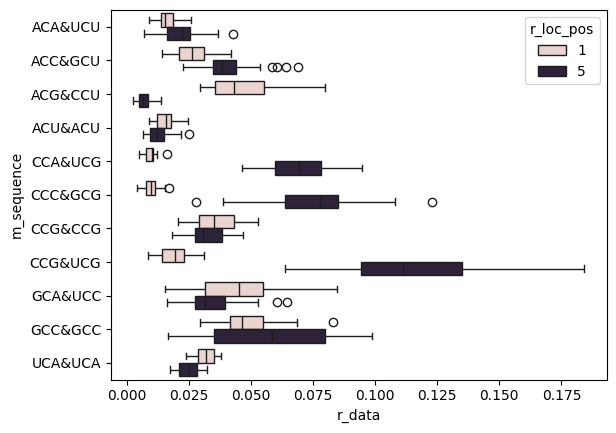

In [37]:
df_sub = df.query("m_token == '1x1' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
sns.boxplot(x="r_data", y="m_sequence", data=df_sub, hue="r_loc_pos")

<Axes: xlabel='r_data', ylabel='m_sequence'>

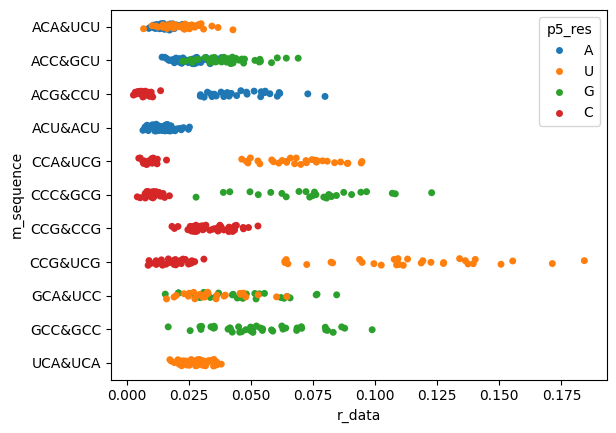

In [38]:
df_sub = df.query("m_token == '1x1' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
df_sub["stack"] = df_sub["p5_res"] + df_sub["p3_res"]
sns.stripplot(x="r_data", y="m_sequence", data=df_sub, hue="p5_res")

<Axes: xlabel='r_data', ylabel='p5_res'>

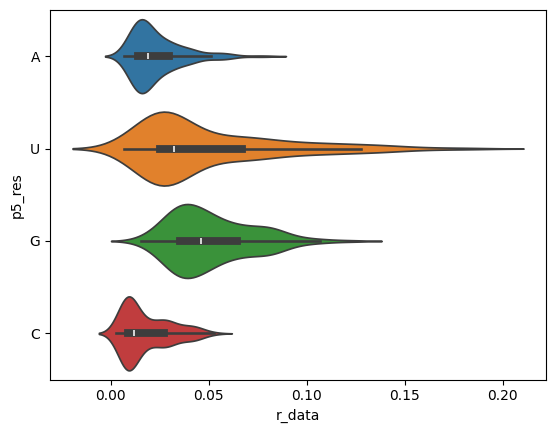

In [39]:
sns.violinplot(x="r_data", y="p5_res", data=df_sub, hue="p5_res")

<Axes: xlabel='r_data', ylabel='m_sequence'>

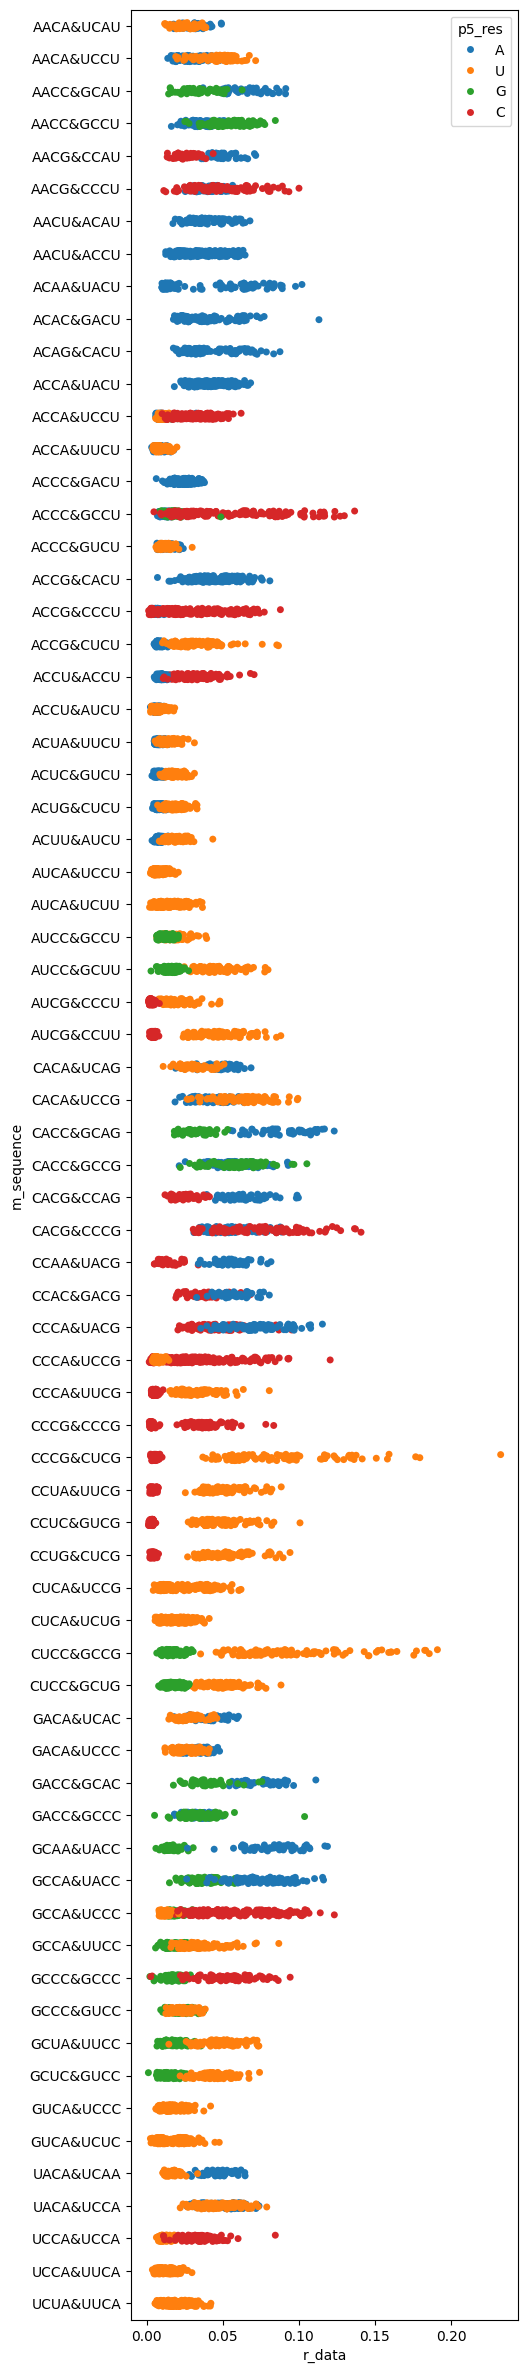

In [40]:
fig, ax = plt.subplots(figsize=(5, 30))
df_sub = df.query("m_token == '2x2' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
sns.stripplot(x="r_data", y="m_sequence", data=df_sub, hue="p5_res")

<Axes: xlabel='r_data', ylabel='p5_res'>

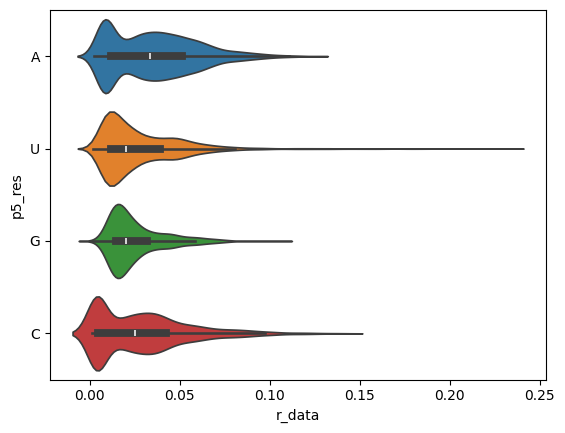

In [41]:
sns.violinplot(x="r_data", y="p5_res", data=df_sub, hue="p5_res")

### A mismatches

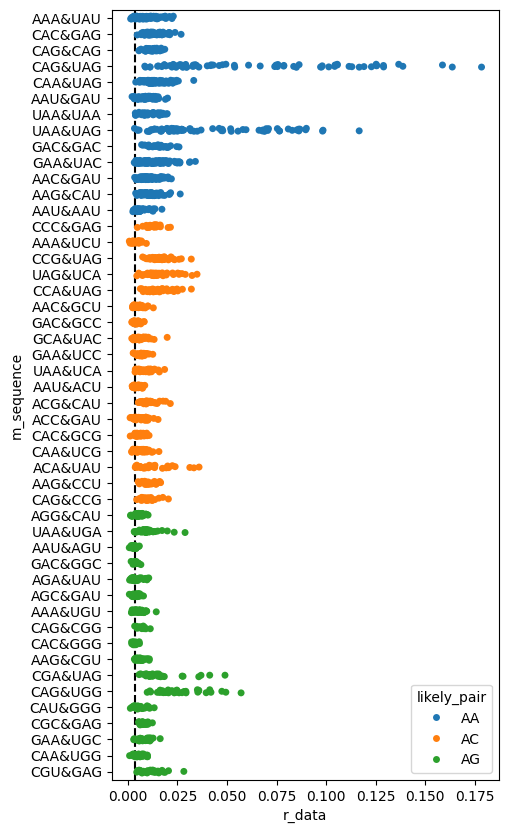

In [42]:
fig, ax = plt.subplots(figsize=(5, 10))
df_sub = df.query("m_token == '1x1' and r_nuc == 'A' and r_type == 'NON-WC'").copy()
df_sub["stack"] = df_sub["p5_res"] + df_sub["p3_res"]
df_sub.sort_values("likely_pair", inplace=True)  
ax = sns.stripplot(x="r_data", y="m_sequence", data=df_sub, hue='likely_pair', ax=ax)
plt.axvline(x=0.00351752, color='black', linestyle='--')

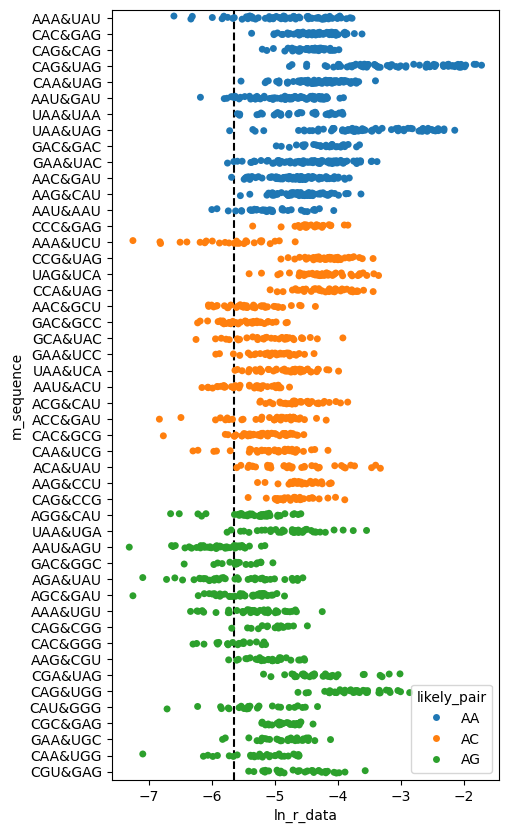

In [43]:
fig, ax = plt.subplots(figsize=(5, 10))
df_sub = df.query("m_token == '1x1' and r_nuc == 'A' and r_type == 'NON-WC'").copy()
df_sub["stack"] = df_sub["p5_res"] + df_sub["p3_res"]
df_sub.sort_values("likely_pair", inplace=True)  
ax = sns.stripplot(x="ln_r_data", y="m_sequence", data=df_sub, hue='likely_pair', ax=ax)
plt.axvline(x=-5.65, color='black', linestyle='--')

In [44]:
count_wc = 0
count_non_wc = 0
for m_sequence, g in df_sub.groupby("m_sequence"):
    ks1, p_val = ks_2samp(g["ln_r_data"], df_wc["ln_r_data"])
    ks2, p_val = ks_2samp(g["ln_r_data"], df_non_wc["ln_r_data"])
    if ks1 < ks2:
        print(m_sequence, ks1, ks2, p_val)
        count_wc += 1
    else:
        count_non_wc += 1
count_wc, count_non_wc

AAA&UCU 0.45563009490711065 0.7703758123917548 2.4706946569223307e-17
AAA&UGU 0.675026165988863 0.705074140738836 1.6334595067589606e-21
AAU&ACU 0.6738437103243367 0.7767264588856446 1.3090324038953905e-26
AAU&AGU 0.45710574695827033 0.8590383131910517 5.86537635086884e-37
AGA&UAU 0.516758441319395 0.6983151501793826 4.915887424645133e-21
AGC&GAU 0.6321578594460276 0.7920884913492268 2.5137119971086275e-27
CAA&UGG 0.666060749115005 0.7143151012011901 5.021028938525127e-17
CAC&GGG 0.6067866052675692 0.8567534805128016 2.7375191068020418e-17
GAC&GCC 0.6865194797511167 0.7728464901002828 5.151365687283568e-25
GAC&GGC 0.6852521243253875 0.8315982808654446 4.437963019406426e-15


(10, 38)

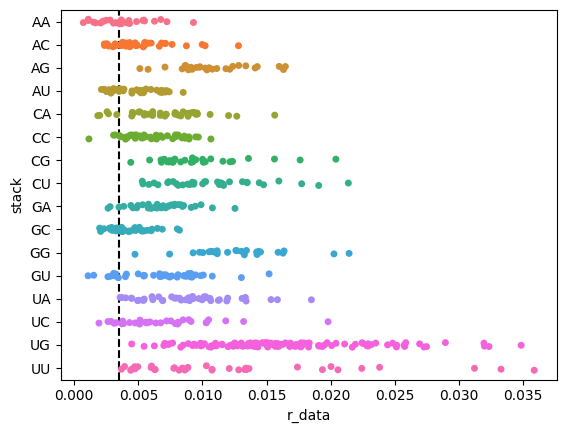

In [45]:
df_sub_2 = df_sub.query('likely_pair == "AC"').copy()
df_sub_2.sort_values("stack", inplace=True)  
sns.stripplot(x="r_data", y="stack", data=df_sub_2, hue="stack")
plt.axvline(x=0.00351752, color='black', linestyle='--')

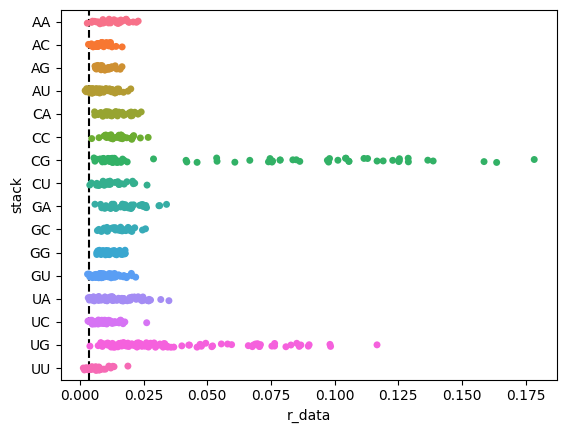

In [46]:
df_sub_2 = df_sub.query('likely_pair == "AA"').copy()
df_sub_2.sort_values("stack", inplace=True)  
sns.stripplot(x="r_data", y="stack", data=df_sub_2, hue="stack")
plt.axvline(x=0.00351752, color='black', linestyle='--')

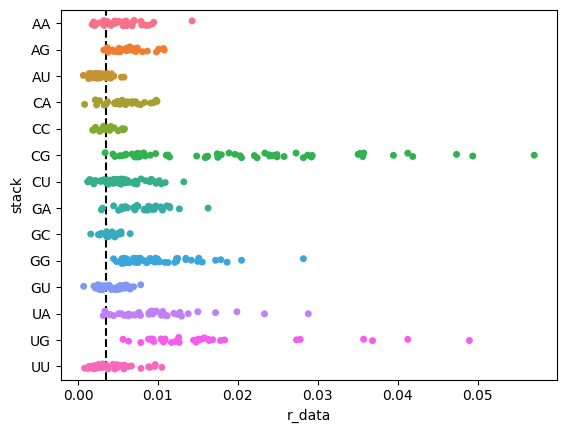

In [47]:
df_sub_2 = df_sub.query('likely_pair == "AG"').copy()
df_sub_2.sort_values("stack", inplace=True)  
sns.stripplot(x="r_data", y="stack", data=df_sub_2, hue="stack")
plt.axvline(x=0.00351752, color='black', linestyle='--')

### 2x2 mismatches

#### C mismatches

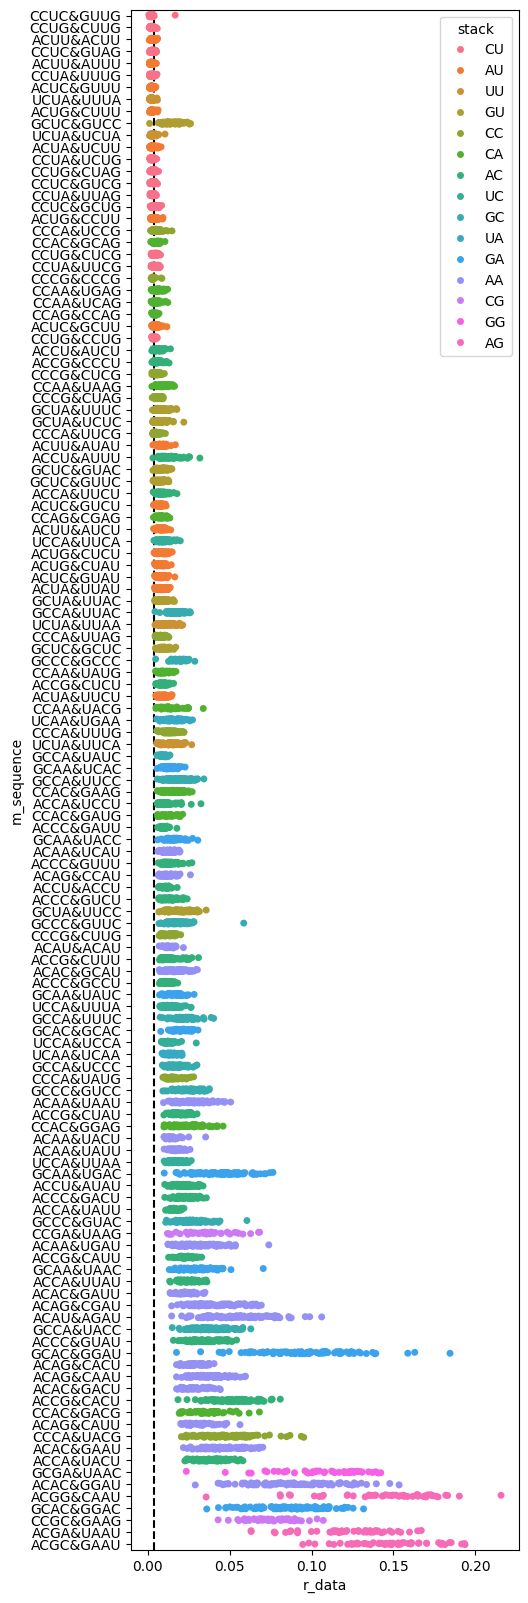

In [48]:
fig, ax = plt.subplots(figsize=(5, 20))
df_sub_pos_1 = df.query("m_token == '2x2' and r_nuc == 'C' and r_type == 'NON-WC' and r_loc_pos == 1").copy()
df_sub_pos_1["m_type"] = "pos_1"
df_sub_pos_1["stack"] = df_sub_pos_1["p5_res"] + df_sub_pos_1["p3_res"]
df_sub_pos_1.sort_values("r_data", inplace=True)  
ax = sns.stripplot(x="r_data", y="m_sequence", data=df_sub_pos_1, ax=ax, hue="stack")
plt.axvline(x=0.00351752, color='black', linestyle='--')

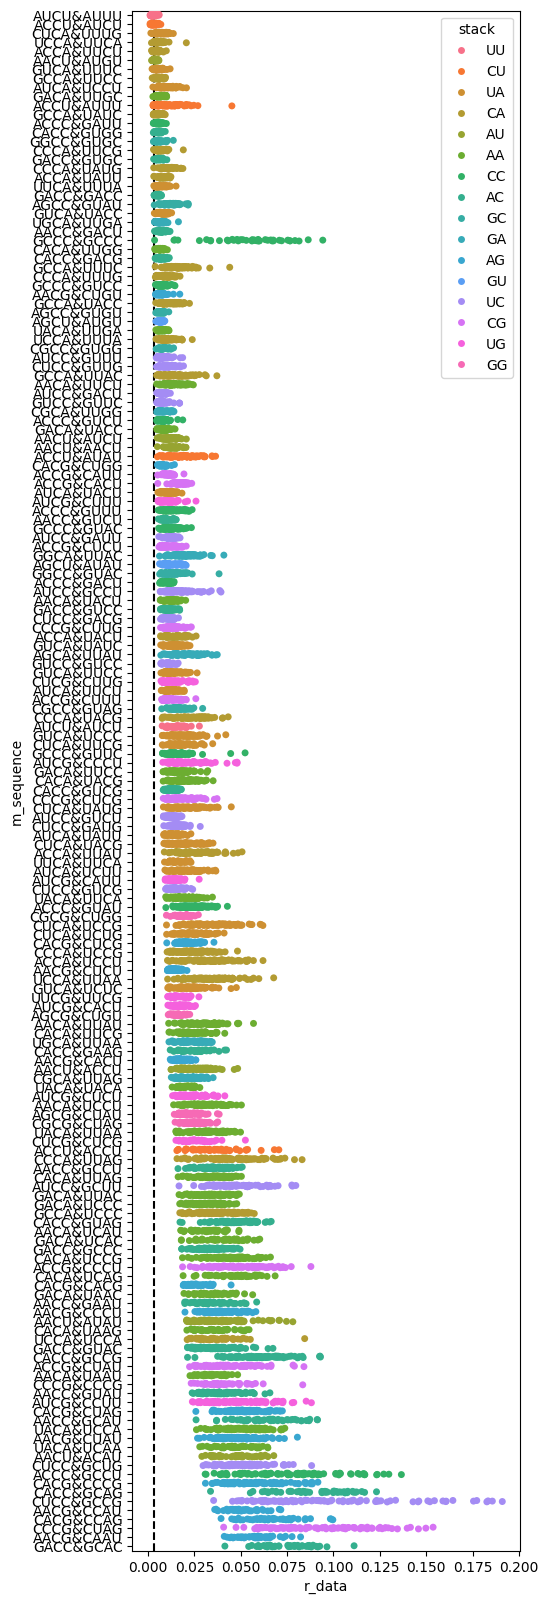

In [49]:
fig, ax = plt.subplots(figsize=(5, 20))
df_sub_pos_2 = df.query("m_token == '2x2' and r_nuc == 'C' and r_type == 'NON-WC' and r_loc_pos == 2").copy()
df_sub_pos_2["m_type"] = "pos_2"
df_sub_pos_2["stack"] = df_sub_pos_2["p5_res"] + df_sub_pos_2["p3_res"]
df_sub_pos_2.sort_values("r_data", inplace=True)  
ax = sns.stripplot(x="r_data", y="m_sequence", data=df_sub_pos_2, ax=ax, hue="stack")
plt.axvline(x=0.00351752, color='black', linestyle='--')

<Axes: xlabel='r_data', ylabel='stack'>

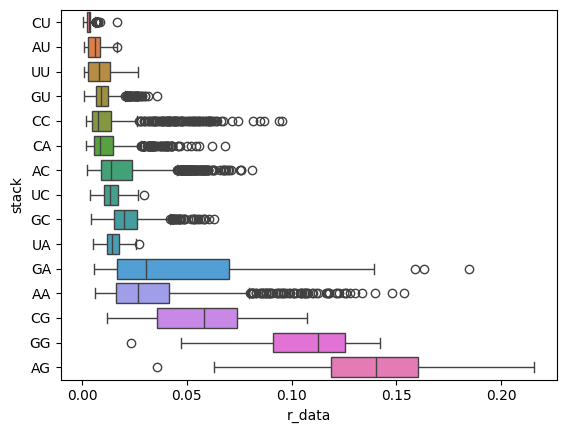

In [50]:
sns.boxplot(x="r_data", y="stack", data=df_sub_pos_1, hue="stack")

<Axes: xlabel='r_data', ylabel='p3_res'>

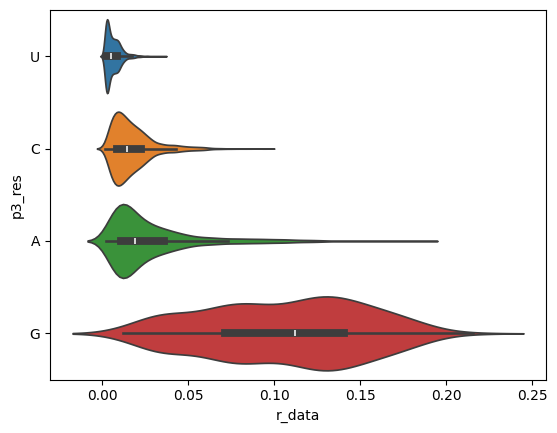

In [51]:
sns.violinplot(x="r_data", y="p3_res", data=df_sub_pos_1, hue="p3_res")

<Axes: xlabel='r_data', ylabel='stack'>

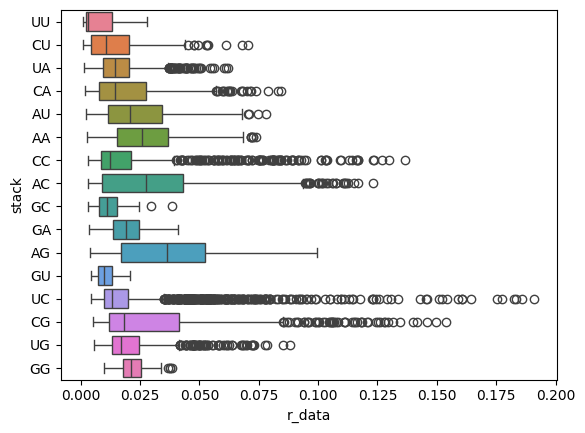

In [52]:
sns.boxplot(x="r_data", y="stack", data=df_sub_pos_2, hue="stack")

<Axes: xlabel='r_data', ylabel='p3_res'>

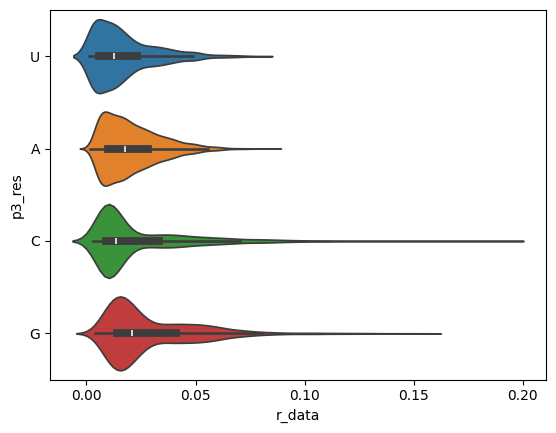

In [53]:
sns.violinplot(x="r_data", y="p3_res", data=df_sub_pos_2, hue="p3_res")

In [54]:
df_merge = pd.concat([df_sub_pos_1, df_sub_pos_2])

<Axes: xlabel='r_data', ylabel='stack'>

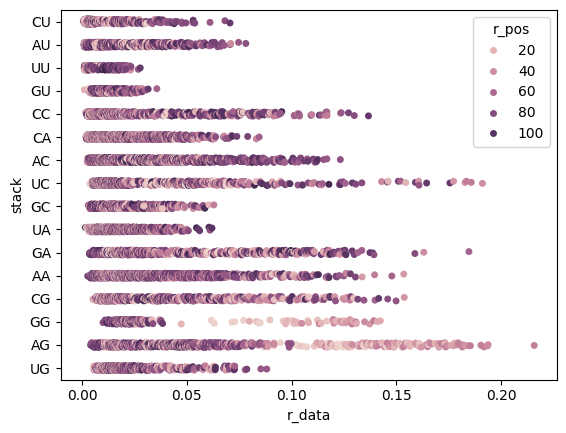

In [55]:
sns.stripplot(x="r_data", y="stack", data=df_merge, hue="r_pos")

In [56]:
df_cut = df_sub_pos_1.query("r_data > 0.15").copy()

In [57]:
df_cut["m_sequence"].unique()

array(['ACGG&CAAU', 'ACGA&UAAU', 'ACGC&GAAU', 'ACAC&GGAU', 'GCAC&GGAU'],
      dtype=object)

### A 2-2 mismatches

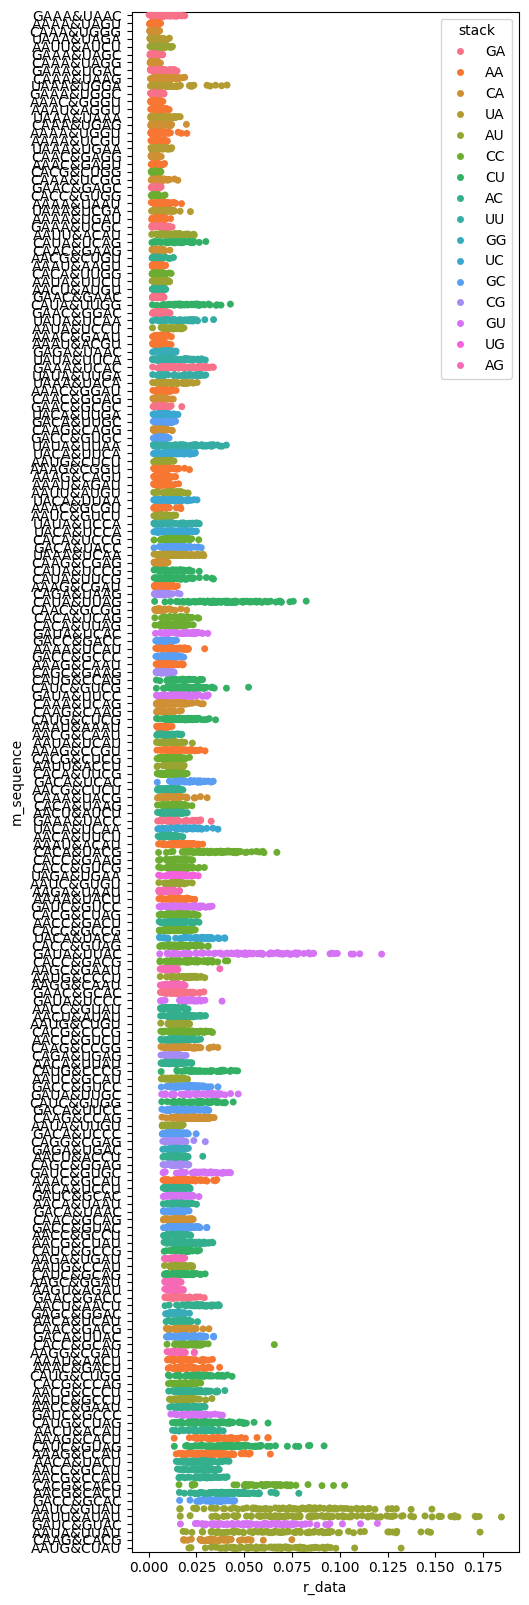

In [58]:
fig, ax = plt.subplots(figsize=(5, 20))
df_sub_pos_1 = df.query("m_token == '2x2' and r_nuc == 'A' and r_type == 'NON-WC' and r_loc_pos == 1").copy()
df_sub_pos_1["m_type"] = "pos_1"
df_sub_pos_1["stack"] = df_sub_pos_1["p5_res"] + df_sub_pos_1["p3_res"]
df_sub_pos_1.sort_values("r_data", inplace=True)  
ax = sns.stripplot(x="r_data", y="m_sequence", data=df_sub_pos_1, ax=ax, hue="stack")

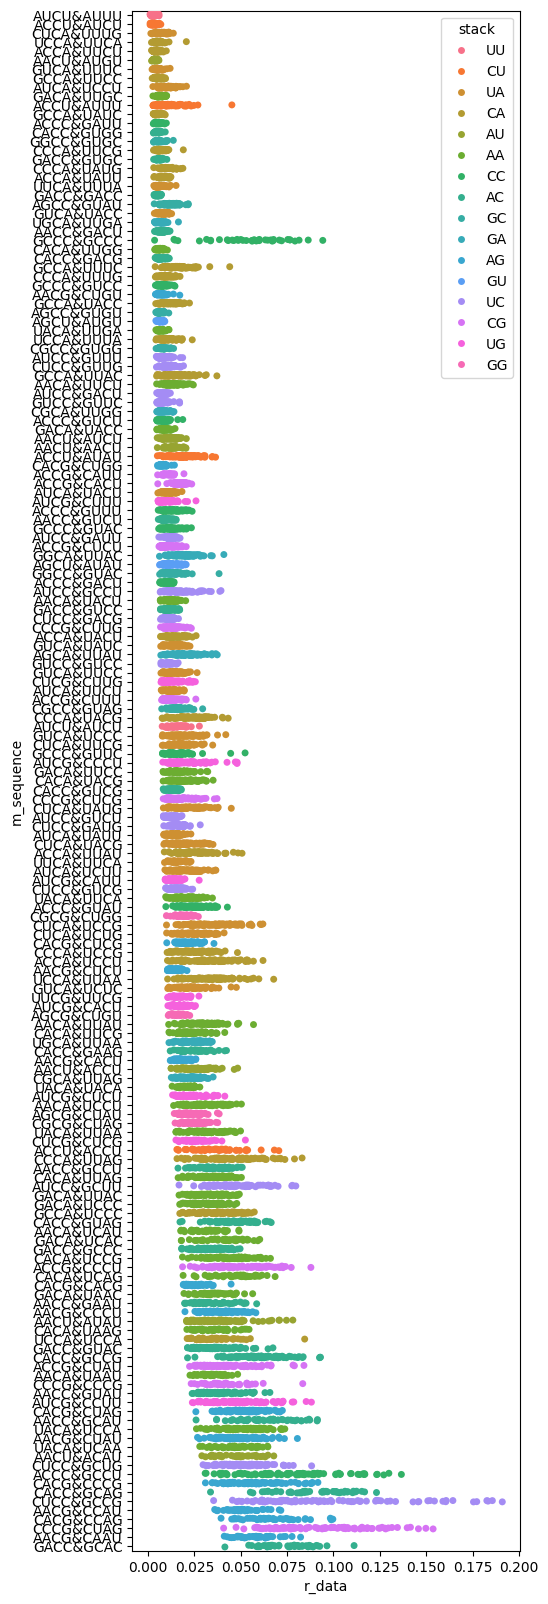

In [59]:
fig, ax = plt.subplots(figsize=(5, 20))
df_sub_pos_2 = df.query("m_token == '2x2' and r_nuc == 'C' and r_type == 'NON-WC' and r_loc_pos == 2").copy()
df_sub_pos_2["m_type"] = "pos_2"
df_sub_pos_2["stack"] = df_sub_pos_2["p5_res"] + df_sub_pos_2["p3_res"]
df_sub_pos_2.sort_values("r_data", inplace=True)  
ax = sns.stripplot(x="r_data", y="m_sequence", data=df_sub_pos_2, ax=ax, hue="stack")

<Axes: xlabel='r_data', ylabel='stack'>

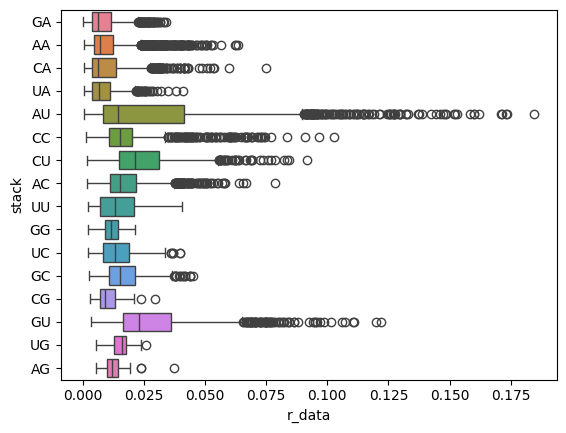

In [60]:
sns.boxplot(x="r_data", y="stack", data=df_sub_pos_1, hue="stack")

<Axes: xlabel='r_data', ylabel='stack'>

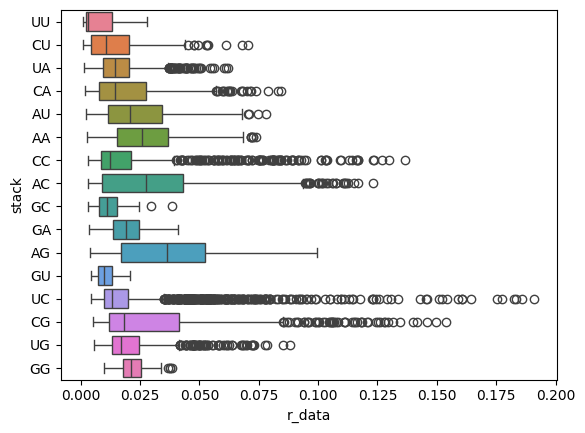

In [61]:
sns.boxplot(x="r_data", y="stack", data=df_sub_pos_2, hue="stack")

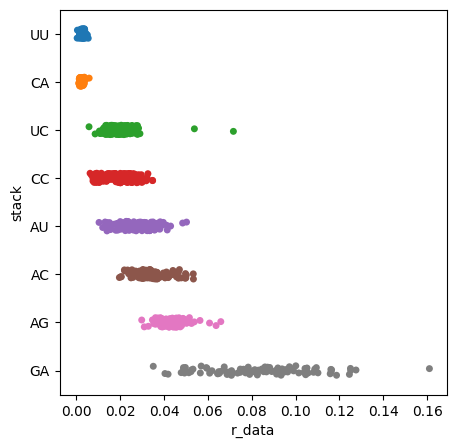

In [62]:
fig, ax = plt.subplots(figsize=(5, 5))
df_sub = df.query("m_token == '3x3' and r_nuc == 'C' and r_type == 'NON-WC'").copy()
df_sub["stack"] = df_sub["p5_res"] + df_sub["p3_res"]
df_sub.sort_values("r_data", inplace=True)  
ax = sns.stripplot(x="r_data", y="stack", data=df_sub, ax=ax, hue="stack")

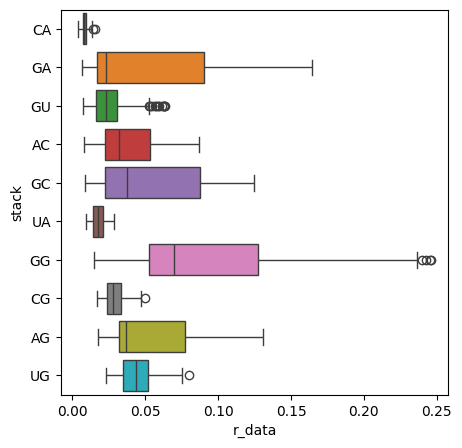

In [63]:
fig, ax = plt.subplots(figsize=(5, 5))
df_sub = df.query("m_token == '3x3' and r_nuc == 'A' and r_type == 'NON-WC'").copy()
df_sub["stack"] = df_sub["p5_res"] + df_sub["p3_res"]
df_sub.sort_values("r_data", inplace=True)  
ax = sns.boxplot(x="r_data", y="stack", data=df_sub, ax=ax, hue="stack")

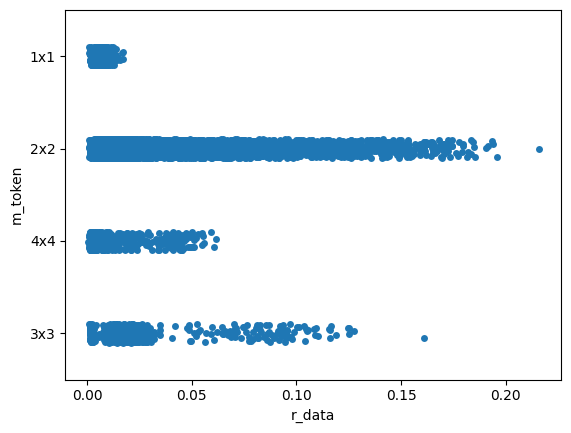

In [64]:
tokens = ["1x1", "2x2", "3x3", "4x4"]
df_sub = df.query("(m_token in @tokens) and (likely_pair == 'CA' or likely_pair == 'AC') and r_nuc == 'C' and r_type == 'NON-WC'").copy()
df_sub["stack"] = df_sub["p5_res"] + df_sub["p3_res"]
ax = sns.stripplot(x="r_data", y="m_token", data=df_sub)

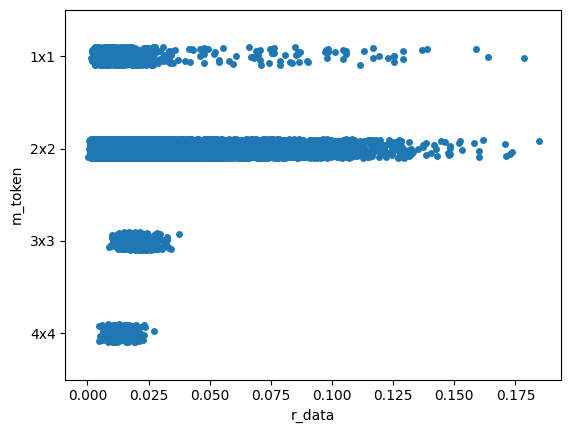

In [65]:
tokens = ["1x1", "2x2", "3x3", "4x4"]
df_sub = df.query("(m_token in @tokens) and (likely_pair == 'AA' or likely_pair == 'AA') and r_nuc == 'A' and r_type == 'NON-WC'").copy()
df_sub["stack"] = df_sub["p5_res"] + df_sub["p3_res"]
ax = sns.stripplot(x="r_data", y="m_token", data=df_sub)

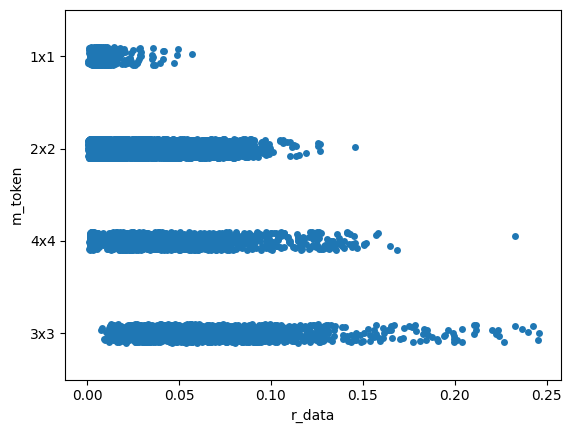

In [66]:
tokens = ["1x1", "2x2", "3x3", "4x4"]
df_sub = df.query("(m_token in @tokens) and (likely_pair == 'AG' or likely_pair == 'GA') and r_nuc == 'A' and r_type == 'NON-WC'").copy()
df_sub["stack"] = df_sub["p5_res"] + df_sub["p3_res"]
ax = sns.stripplot(x="r_data", y="m_token", data=df_sub)

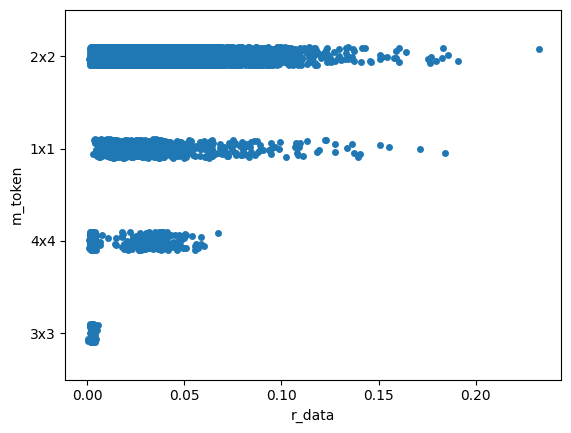

In [67]:
tokens = ["1x1", "2x2", "3x3", "4x4"]
df_sub = df.query("(m_token in @tokens) and (likely_pair == 'CC' or likely_pair == 'CC') and r_nuc == 'C' and r_type == 'NON-WC'").copy()
df_sub["stack"] = df_sub["p5_res"] + df_sub["p3_res"]
ax = sns.stripplot(x="r_data", y="m_token", data=df_sub)

## probability

In [68]:
df_non_wc = df.query("r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C')").copy()
df_sub_1 = df_non_wc.query("ln_r_data < -5.46").copy()
df_sub_1.value_counts("m_token")

m_token
2x2    9300
1x1     581
4x4     578
3x2     336
3x1     264
3x3     205
5x4     181
6x3     157
4x3     105
5x3      80
2x1      36
4x2      36
1x0      18
5x0      16
2x0      13
5x1       8
3x0       1
4x1       1
dtype: int64

In [69]:
df_sub_1.value_counts("likely_pair")

likely_pair
AG    3232
CU    2914
AA    1722
      1252
CA    1224
CC     958
AC     614
dtype: int64

In [70]:
df_non_wc = df.query("r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C')").copy()
count = 0
total = 0
for [r_loc_pos, m_sequence], g in df_non_wc.groupby(["r_loc_pos", "m_sequence"]):
    avg = g["ln_r_data"].mean()
    if avg < -5.46:
        count += 1
    total += 1
total, count, count/total * 100

(1745, 130, 7.4498567335243555)

In [71]:
df_non_wc = df.query("r_type == 'WC' and (r_nuc == 'A' or r_nuc == 'C')").copy()
count = 0
total = 0
for [r_loc_pos, m_sequence], g in df_non_wc.groupby(["r_loc_pos", "m_sequence"]):
    avg = g["ln_r_data"].mean()
    if avg > -5.46:
        count += 1
    total += 1
total, count, count/total * 100

(1378, 121, 8.780841799709723)

## stacking

<Axes: xlabel='ln_r_data', ylabel='stack'>

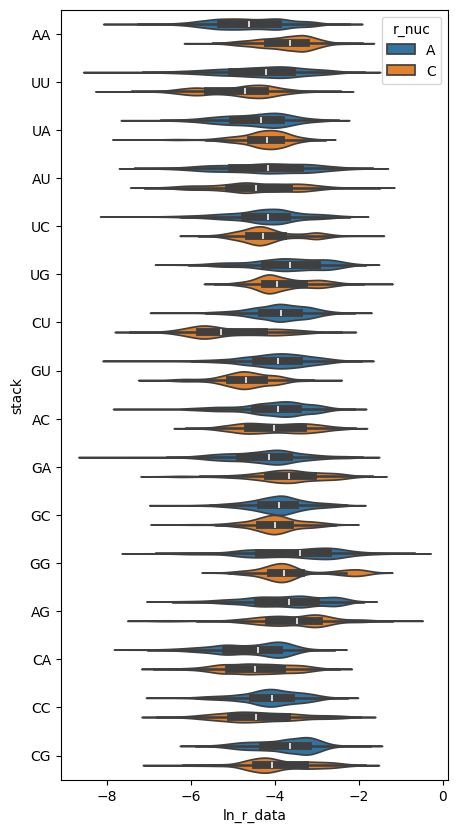

In [113]:
df_non_wc = df.query("r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C')").copy()
df_non_wc["stack"] = df_non_wc["p5_res"] + df_non_wc["p3_res"]
fig, ax = plt.subplots(figsize=(5, 10))
sns.violinplot(x="ln_r_data", y="stack", data=df_non_wc, hue="r_nuc")
#plt.axvline(x=-0.82390874, color='black', linestyle='--')

<Axes: xlabel='ln_r_data', ylabel='p3_res'>

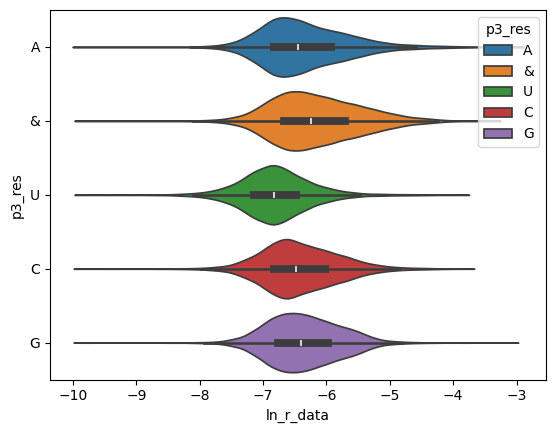

In [73]:
sns.violinplot(x="ln_r_data", y="p3_res", data=df_non_wc, hue="p3_res")


<Axes: xlabel='ln_r_data', ylabel='stack'>

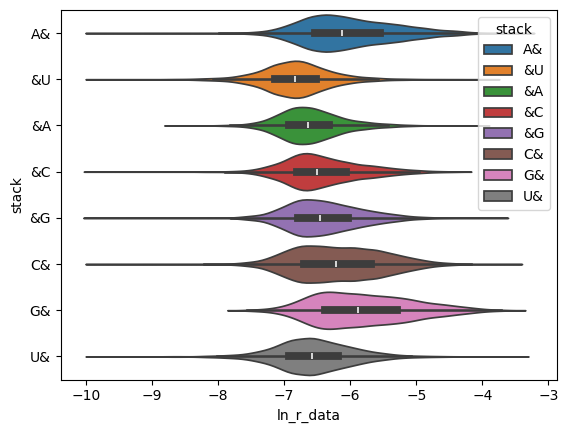

In [74]:
sns.violinplot(x="ln_r_data", y="stack", data=df_non_wc, hue="stack")


In [75]:
df_non_wc_pair = df_non_wc.query("likely_pair != ''").copy()


<Axes: xlabel='ln_r_data', ylabel='p5_res'>

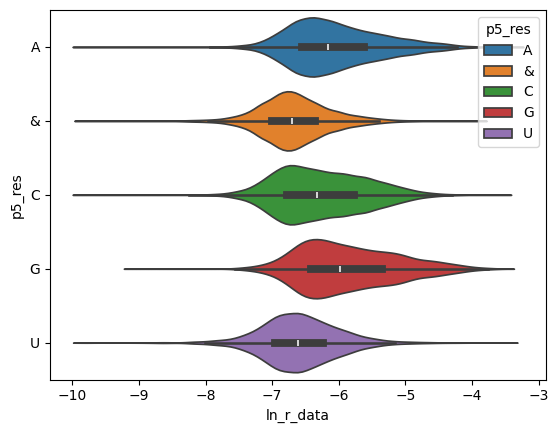

In [76]:
sns.violinplot(x="ln_r_data", y="p5_res", data=df_non_wc_pair, hue="p5_res")


<Axes: xlabel='ln_r_data', ylabel='stack'>

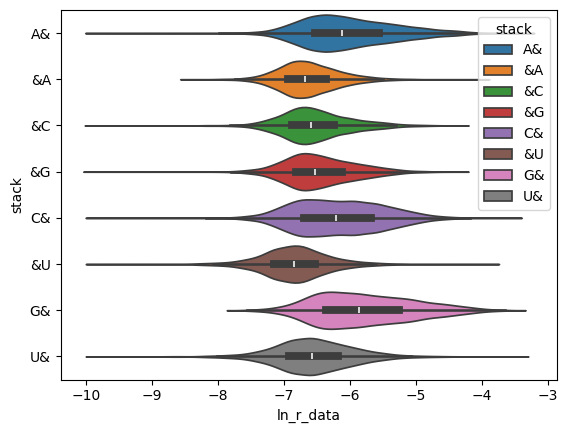

In [77]:
sns.violinplot(x="ln_r_data", y="stack", data=df_non_wc_pair, hue="stack")


In [78]:
df_non_wc_pair = df_non_wc.query("likely_pair != '' and r_nuc == 'C'").copy()


<Axes: xlabel='ln_r_data', ylabel='p3_res'>

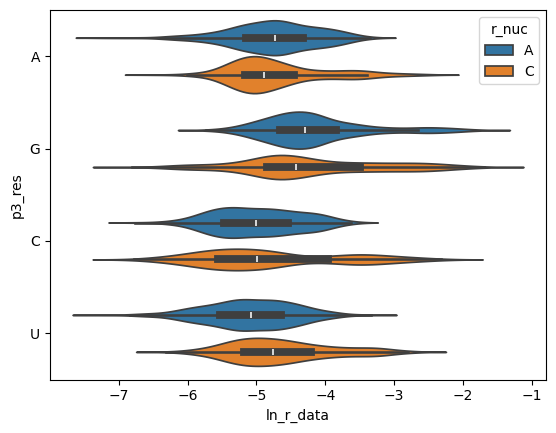

In [102]:
sns.violinplot(x="ln_r_data", y="p3_res", data=df_non_wc_pair, hue="r_nuc" )

<Axes: xlabel='ln_r_data', ylabel='p5_res'>

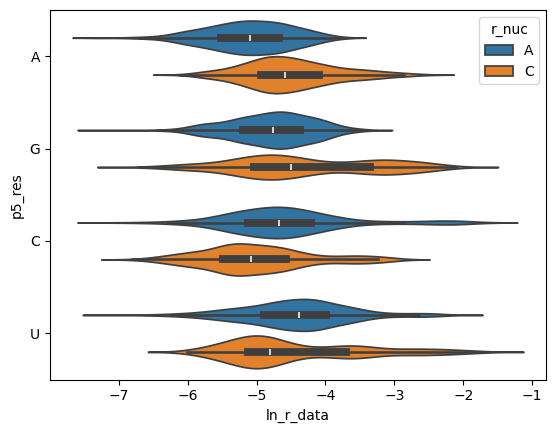

In [106]:
sns.violinplot(x="ln_r_data", y="p5_res", data=df_non_wc_pair, hue="r_nuc")

In [114]:
def assign_stack_type(row):
    if row["both_pyrimidine"]:
        return "both_pyrimidine"
    elif row["both_purine"]:
        return "both_purine"
    else:
        return "mixed"

<Axes: xlabel='ln_r_data', ylabel='stack_type'>

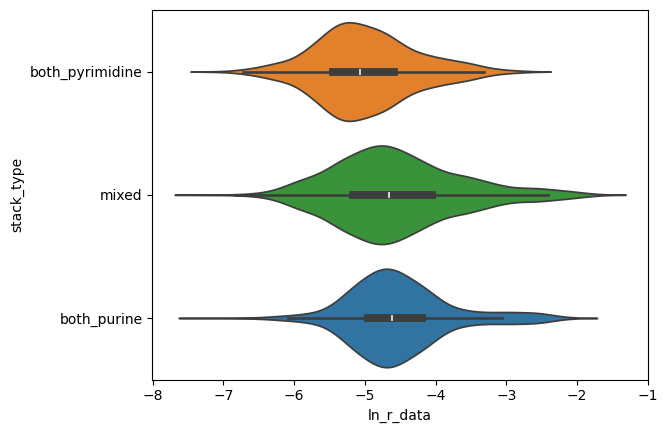

In [117]:
df_non_wc_pair["stack_type"] = df_non_wc_pair.apply(assign_stack_type, axis=1)
sns.violinplot(data=df_non_wc_pair, y="stack_type", x="ln_r_data", hue="stack_type", order=["both_pyrimidine", "mixed", "both_purine"])

<Axes: xlabel='ln_r_data', ylabel='stack_type'>

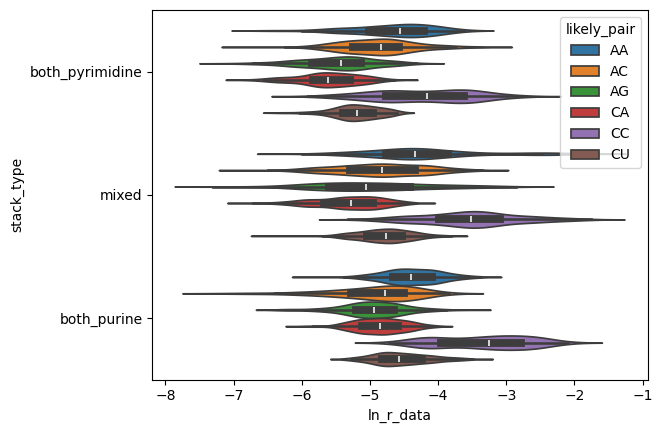

In [119]:
sns.violinplot(data=df_non_wc_pair, y="stack_type", x="ln_r_data", hue="likely_pair", order=["both_pyrimidine", "mixed", "both_purine"])

In [80]:
df_high = df_non_wc.query("r_data > 0.15").copy()

In [81]:
for (nuc, m_token), full_g in df_non_wc.groupby(["r_nuc", "m_token"]):
    g = df_high.query(f"r_nuc == '{nuc}' and m_token == '{m_token}'")
    if len(g) == 0:
        continue
    print(f"{nuc} {m_token} {g.shape[0]}/{full_g.shape[0]}, percentage: {g.shape[0]/full_g.shape[0]*100}")

In [82]:
df_high["stack"].value_counts()

Series([], Name: stack, dtype: int64)

In [83]:
df_non_wc["stack"].value_counts()

A&    13537
C&    11824
U&     7247
&U     5176
&A     3579
&C     3503
G&     2850
&G     2471
Name: stack, dtype: int64

### topology analysis

In [84]:
def plot_violinplot_w_percent(df: pd.DataFrame, x: str, y: str, cutoff=-5.65, color="tab:blue", gt_lt="greater", text_pos=-7.75, ax=None) -> plt.Axes:
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    sns.violinplot(x=x, y=y, data=df, color=color, density_norm='width', ax=ax)
    ax.axvline(cutoff, color='red', linestyle='--')
    count = 0
    for group_name, g in df.groupby(y):
        if gt_lt == "greater":
            percent = (g[x] > cutoff).sum() / len(g)
        elif gt_lt == "less":
            percent = (g[x] < cutoff).sum() / len(g)
        percent *= 100
        ax.text(text_pos, count+0.020, f"{percent:.2f}%", va='center', ha='right', size=20, name="Arial")
        print(group_name, percent)
        count += 1
    return ax

In [85]:
df_non_wc_pair = df.query("r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != '' and m_token == '1x1'").copy()
df_non_wc_pair["cat"] = ""
for group_keys, group in df_non_wc_pair.groupby(["m_token", "r_nuc", "likely_pair"]):
    df_non_wc_pair.loc[group.index, "cat"] = "-".join(list(group_keys[2]))
    print (group_keys, len(group), len(group[group["ln_r_data"] < -5.45])/len(group))

('1x1', 'A', 'AA') 866 0.046189376443418015
('1x1', 'A', 'AC') 674 0.17210682492581603
('1x1', 'A', 'AG') 563 0.29307282415630553
('1x1', 'C', 'CA') 674 0.33086053412462907
('1x1', 'C', 'CC') 672 0.008928571428571428
('1x1', 'C', 'CU') 624 0.07211538461538461


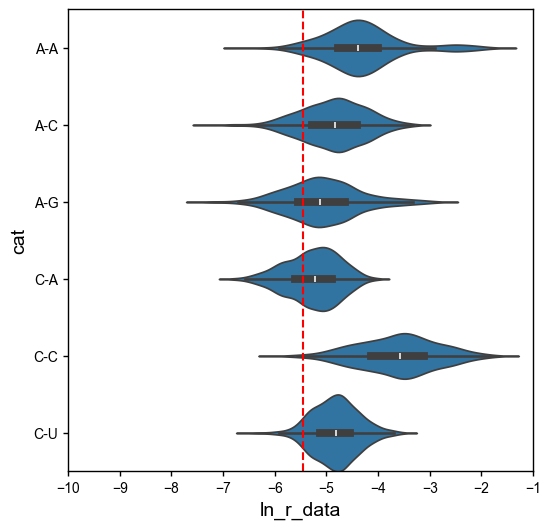

In [86]:
fig, ax = plt.subplots(figsize=(6, 6))
df_non_wc_pair.sort_values("cat", inplace=True)
ax = sns.violinplot(x="ln_r_data", y="cat", data=df_non_wc_pair, width=1.0, ax=ax)
#ax = sns.stripplot(x="ln_r_data", y="cat", data=df_non_wc_pair, ax=ax, s=0.5, jitter=0.25, color="black", alpha=.5)
plt.axvline(x=-5.45, color='red', linestyle='--')
ax.set_xlim([-10, -1])
publication_style_ax(ax)



A-A 4.618937644341801
A-C 17.210682492581604
A-G 29.307282415630553
C-A 33.08605341246291
C-C 0.8928571428571428
C-U 7.211538461538461


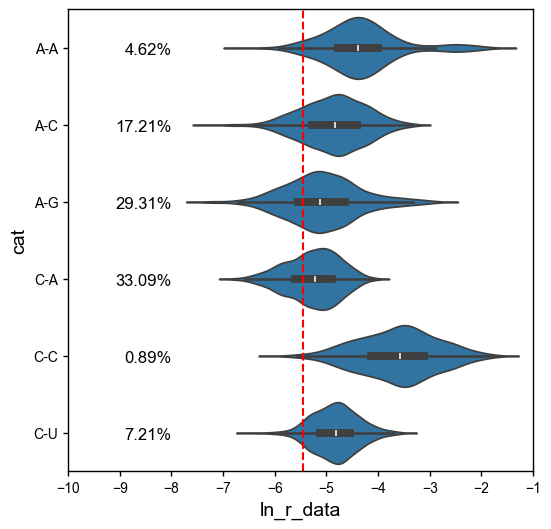

In [87]:
ax = plot_violinplot_w_percent(df_non_wc_pair, "ln_r_data", "cat", -5.45, "tab:blue", "less", text_pos=-8)
ax.set_xlim([-10, -1])
publication_style_ax(ax)

In [88]:
m_tokens = ["1x0", "2x0", "3x0"]
df_non_wc_no_pair = df.query("r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and m_token in @m_tokens").copy()
df_non_wc_no_pair["cat"] = ""
for group_keys, group in df_non_wc_no_pair.groupby(["m_token", "r_nuc"]):
    df_non_wc_no_pair.loc[group.index, "cat"] = f"{group_keys[0]} {group_keys[1]}"
    print (group_keys, len(group), len(group[group["ln_r_data"] < -5.45])/len(group))
df_non_wc_no_pair = df_non_wc_no_pair.query("cat != ''")

('1x0', 'A') 335 0.05373134328358209
('1x0', 'C') 186 0.0
('2x0', 'A') 508 0.025590551181102362
('2x0', 'C') 175 0.0
('3x0', 'A') 334 0.0029940119760479044
('3x0', 'C') 482 0.0


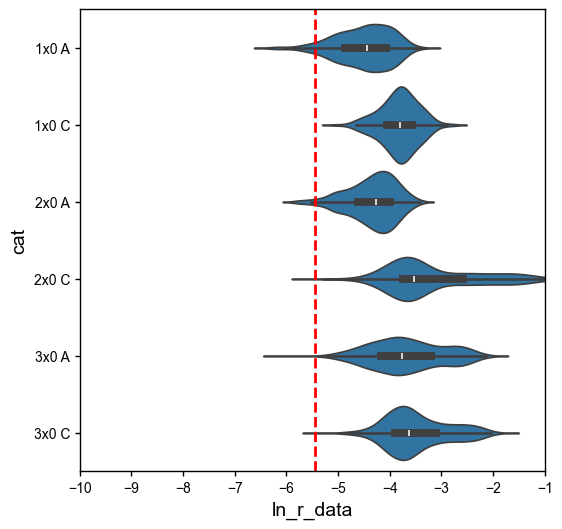

In [89]:
fig, ax = plt.subplots(figsize=(6, 6))
df_non_wc_no_pair.sort_values("cat", inplace=True)
ax = sns.violinplot(x="ln_r_data", y="cat", data=df_non_wc_no_pair, width=1.0, ax=ax)
plt.axvline(x=-5.45, color='red', linestyle='--', lw=2)
ax.set_xlim([-10, -1])
publication_style_ax(ax)


In [90]:
df_residue_avg = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_avg.json")
df_residue_avg["ln_r_avg"] = np.log(df_residue_avg["r_avg"])
df_residue_avg = df_residue_avg.query("r_type == 'NON-WC' and likely_pair != ''").copy()


In [91]:
df_residue_avg["cat"] = ""
for group_keys, group in df_residue_avg.groupby(["m_token", "r_nuc", "likely_pair"]):
    df_residue_avg.loc[group.index, "cat"] = f"{group_keys[0]}_{group_keys[1]}_{group_keys[2]}"

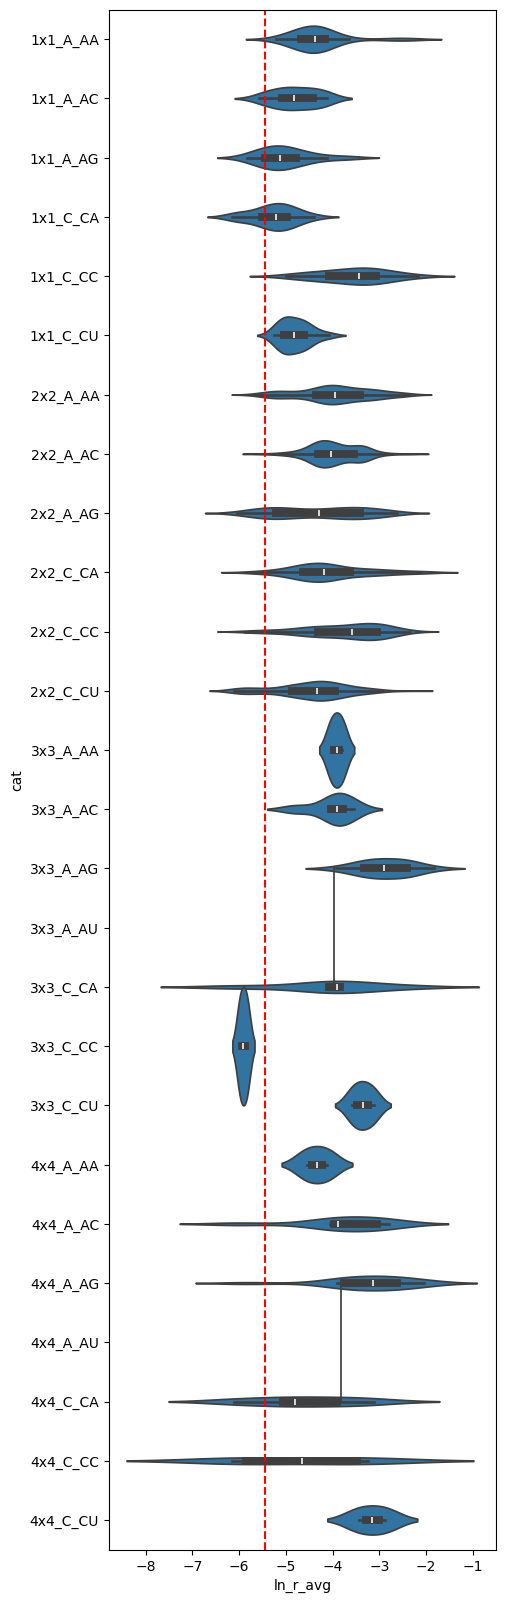

In [92]:
fig, ax = plt.subplots(figsize=(5, 20))
df_residue_avg.sort_values("cat", inplace=True)
ax = sns.violinplot(x="ln_r_avg", y="cat", data=df_residue_avg, ax=ax, width=2)
plt.axvline(x=-5.45, color='red', linestyle='--')
#plt.axvline(x=0.00351752, color='red', linestyle='--')

In [93]:
df_lower = df_wc.query("ln_r_data > -5.45").copy()

In [94]:
df_lower["p3_res"].value_counts()

&    5868
A    1700
C     845
G     497
U     311
Name: p3_res, dtype: int64